# <font style="color:blue">Project 1 - Part 1: Data Understanding & Pipeline Check</font>


Here, we will slightly modify the steps that we used earlier to train Neural Networks:

* Step 1 - Understand your problem
* Step 2 - Dataset Exploration
    * Step 2A - Get the data
    * Step 2B - Explore & understand your data
    * Step 2C - Create a sample data from the dataset
* Step 3 - Data preparation
* Step 4 - Train a simple model on sample data, and check the pipeline before training the full network
* Step 5 - Train on full data
* Step 6 - Improve your model
* Step 7 - Generate Submission file


In this notebook, we will detail the steps 1 to 4, and do some coding along the way! You will implement Steps 5, 6 & 7 in the next notebook.

This notebook carries **`25 points`** out of a total **`100`**. <br>
<font style="color:red">The sections in red carry marks.</font>


#### Points Distribution - Maximum Points: 25


<div align="center">
    <table>
        <tr><td><h3>Number</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Explore Dataset</h3></td> <td><h3>6</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Data Preparation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Configurations</h3></td> <td><h3>4</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Display Mistakes</h3></td><td><h3>10</h3></td> </tr>
    </table>
</div>

# <font style="color:blue">Step 1: Understand Your Problem </font>

As you already know, Image Classification helps classify an image based on its visual content. So, the model is supposed to look at the given image and predict which object is present in it. Obviously, the objects which it can predict depends on the objects you have trained it on.


In our problem, we want to classify an input image by distinguishing among  **4 animals - cow, elephant, horse and spider**.


### <font style="color:green">What Do We Need and How to Achieve It? </font>

1. You need correctly-labeled images of each animal.
2. Also, you need to train a network to understand the input image.

In [1]:
# Colab-gdrive import
from google.colab import drive; drive.mount("/remote/")

# Built-in imports
import os
import random
import glob as glob

# Third-party imports
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow import keras as tfk

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from dataclasses import dataclass
import platform


# Text formatting
bold = "\033[1m"
end = "\033[0m"

block_plot=False

%matplotlib inline

Mounted at /remote/


### <font style="color:green">Set Seeds</font>

Use this function to set random seeds for CPU and GPU operations in order to make training deterministic and to ensure reproducibility.

In [2]:
def set_seeds():
  # fix random seeds
  SEED_VALUE = 42

  random.seed(SEED_VALUE)
  np.random.seed(SEED_VALUE)
  tf.random.set_seed(SEED_VALUE)
  os.environ["TF_DETERMINISTIC_OPS"] = "1"

  gpus = tf.config.experimental.list_physical_devices('GPU')
  if gpus:
    try:
      # Currently, memory growth needs to be the same across GPUs
      for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
      # Memory growth must be set before GPUs have been initialized
      print(e)

  return

set_seeds()

# Creating a MirroredStrategy for distributed training.
# This strategy effectively replicates the model's layers on each GPU or other available devices,
# syncing their weights after each training step.
DISTRIBUTE_STRATEGY = tf.distribute.MirroredStrategy()

# Printing the number of devices that are in sync with the MirroredStrategy.
# This indicates how many replicas of the model are being trained in parallel.
print('Number of devices: {}'.format(DISTRIBUTE_STRATEGY.num_replicas_in_sync))

Number of devices: 1


# <font style="color:blue">Step 2: Dataset Exploration</font>

## <font style="color:blue">Step 2A: Get the Data </font>

Let’s use a dataset from kaggle. [**Check it out here**](https://www.kaggle.com/c/opencv-tensorflow-course-classication-project-1/data).

We have already separated the dataset into training, validation and test splits for you.

## <font style="color:blue">Step 2B: Explore & Understand your data [6 Points]</font>


**Set Data Paths**

In [3]:
@dataclass(frozen=True)
class DatasetConfig:
  """Dataset configuration class.
  """
  NUM_CLASSES: int = 4
  SHAPE: tuple = (224, 224, 3)

  DATASET_DIR: str = "/remote/MyDrive/shared/dataset/opencv-TF-course-project-1-image-classification/dataset"
  TRAIN_DIR: str = f"{DATASET_DIR}/Train"
  VALID_DIR: str = f"{DATASET_DIR}/Valid"
  TEST_DIR: str = f"{DATASET_DIR}/Test"

  AUGMENTATION: bool = True
  BATCH_SIZE:   int  = 32

  SEED = 2000


@dataclass
class TrainingConfig:
  BATCH_SIZE: int = 4 * DISTRIBUTE_STRATEGY.num_replicas_in_sync

  EPOCHS: int = 30
  LEARNING_RATE: float = 0.001
  MULTIPROCESSING: bool = True if platform.system() == "Linux" else False
  WORKERS: int = 4

  # For tensorboard logging and saving checkpoints
  MODEL_NAME: str = "Classifier4"
  MODEL_DIR: str = f"/remote/MyDrive/Colab Notebooks/models/{MODEL_NAME}"
  CHECKPOINT_DIR: str = f"{MODEL_DIR}/{MODEL_NAME}.keras"
  SUBMISSION_DIR: str = f"{MODEL_DIR}/submission.csv"


  root_log_dir: str = "/remote/MyDrive/Colab Notebooks/models/Model_logs"
  root_checkpoint_dir: str = "/remote/MyDrive/Colab Notebooks/models/Model_checkpoints"
  # Current log and checkpoint directory.
  log_dir = "version_0"
  checkpoint_dir = "version_0"


@dataclass
class OptimizerConfig:
  INIT_LEARING_RATE: float = 0.0001
  WEIGHT_DECAY:      float = 0.00001
  # At which epochs should we make a "step" in the learning rate (i.e. decrease it in some manner)
  STEP_MILESTONE = (TrainingConfig.EPOCHS//2,)
  # Multiplier applied to current learning rate at each of STEP_MILESTONE
  GAMMA: float = 0.1

### <font style="color:green">Folder Structure </font>

In [ ]:
def list_folders(startpath):
  for root, _, files in os.walk(startpath):
    level = root.replace(startpath, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root):<8}')


list_folders(DatasetConfig.DATASET_DIR)

dataset 
    Train   
        spider  
        cow     
        elephant
        horse   
    Valid   
        spider  
        elephant
        horse   
        cow     
    Test    


### <font style="color:green">List the Classes</font>

It simply prints the sub folders present under the training or validation folder.

In [ ]:
print(f"{bold}Training Classes:{end} ")
for i in os.listdir(DatasetConfig.TRAIN_DIR):
  print(i)

print("------------")

print(f"{bold}Validation Classes:{end} ")
for j in os.listdir(DatasetConfig.VALID_DIR):
  print(j)

Training Classes: 
spider
cow
elephant
horse
------------
Validation Classes: 
spider
elephant
horse
cow


### <font style="color:red">Find the Number of Samples in Training and Validation Folders [2 Points]</font>

In [ ]:
num_train_files = 0
num_valid_files = 0

### YOUR CODE HERE
num_train_files = glob.glob(f"{DatasetConfig.TRAIN_DIR}/**/*").__len__()
num_valid_files = glob.glob(f"{DatasetConfig.VALID_DIR}/**/*").__len__()
###

print(f"{bold}Number of Training samples: {end}{num_train_files}")
print(f"{bold}Number of Validation samples: {end}{num_valid_files}")

Number of Training samples: 3997
Number of Validation samples: 786


### <font style="color:red">Display Some Samples and the Size of the Image[4 Points]</font>

**Display one sample for each class**

Choose randomly one sample from each class folder in the `Train` directory.

1. Load image using `PIL.Image` or `matplotlib` or `opencv`.
2. Print size/shape of the image.
3. Display image file using matplotlib.

**A sample output:**

<img src="https://learnopencv.com/wp-content/uploads/2022/05/c4-pa1-data_pipeline_check-sample_image.png" width="40%">

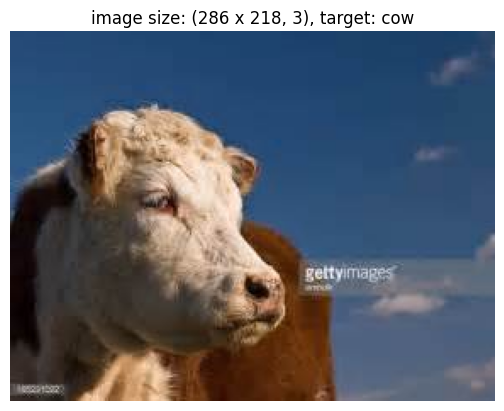

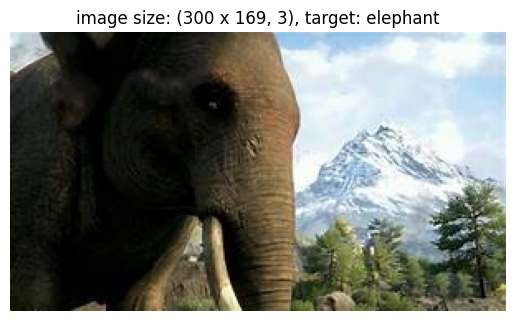

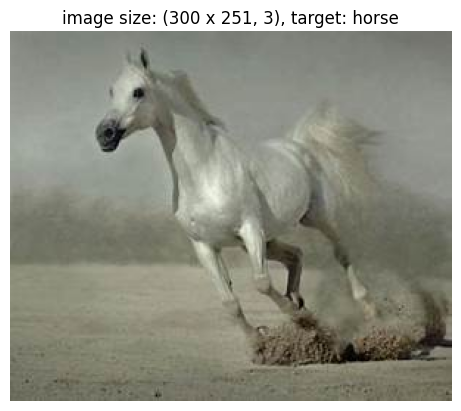

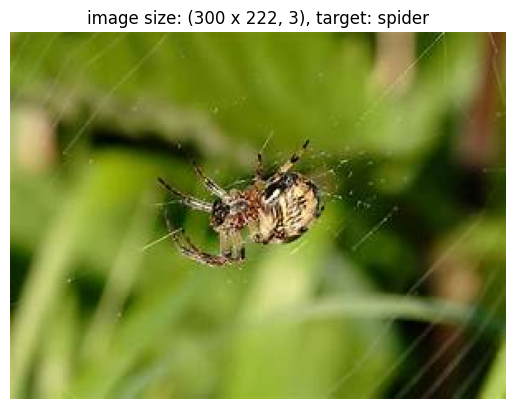

In [6]:
def show_image(image_path, label):
  img = cv.imread(image_path)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  height, width, channels = img.shape

  plt.imshow(img)
  plt.title(f"image size: ({width} x {height}, {channels}), target: {label}")
  plt.axis("off")
  plt.show()


target = "cow"
# Load image and print its shape/size.
### YOUR CODE HERE
train_cow_images = glob.glob(f"{DatasetConfig.TRAIN_DIR}/{target}/*jpg")
show_image(train_cow_images[11], target)
###


target = "elephant"
# Load image and print its shape/size.
### YOUR CODE HERE
train_elephant_images = glob.glob(f"{DatasetConfig.TRAIN_DIR}/{target}/*jpg")
show_image(train_elephant_images[22], target)
###


target = "horse"
# Load image and print its shape/size.
### YOUR CODE HERE
train_horse_images = glob.glob(f"{DatasetConfig.TRAIN_DIR}/{target}/*jpg")
show_image(train_horse_images[33], target)
###


target = "spider"
# Load image and print its shape/size.
### YOUR CODE HERE
train_spider_images = glob.glob(f"{DatasetConfig.TRAIN_DIR}/{target}/*jpg")
show_image(train_spider_images[33], target)
###

# <font style="color:red">Step 3. Data Preparation [5 Points]</font>


Now that you have seen how the data is organized, it's time to configure the train and valid generators to feed to the training pipeline.

* For this notebook, you have to create a `data_augmentation_preprocess()` function that returns a `Sequential model` made up of different augmentation layers.
* The augmentation pipeline returned from this function will be applied using the `Dataset.map()` method as part of data loading.
* Using this approach, the dataset will yield batches of augmented images.

* Starting from the **Training from Scratch** notebook, you can use:
    * Option 1: [Make the preprocessing layers part of your model.](https://www.tensorflow.org/tutorials/images/data_augmentation#option_1_make_the_preprocessing_layers_part_of_your_model)
    * Option 2: [Apply the preprocessing layers to your dataset.](https://www.tensorflow.org/tutorials/images/data_augmentation#option_2_apply_the_preprocessing_layers_to_your_dataset)

### <font style="color:red">Task [3 points]</font>

**Create a function `data_augmentation_preprocess()` to apply augmentations.**


```python
def data_augmentation_preprocess():
    # Combine multiple augmentations in a single processing pipeline.
    data_augmentation_pipeline = ...
    
    return data_augmentation_pipeline
```

**Reference:** https://www.tensorflow.org/tutorials/images/data_augmentation#data_augmentation_2

In [4]:
### YOUR CODE HERE
def data_augmentation_preprocess():
  """Combines multiple augmentations in a single processing pipeline.

  Reference:
    https://www.tensorflow.org/tutorials/images/data_augmentation#data_augmentation_2

  """
  return tfk.Sequential([
    tfk.layers.RandomFlip("horizontal", seed=DatasetConfig.SEED),
    tfk.layers.RandomFlip("vertical", seed=DatasetConfig.SEED),
    tfk.layers.RandomRotation(0.25, fill_mode='nearest', seed=DatasetConfig.SEED),
    tfk.layers.RandomZoom(
      height_factor=(-.5, .5),
      width_factor=(-.5, .5),
      fill_mode='nearest',
      seed=DatasetConfig.SEED
    ),
    tfk.layers.RandomContrast(0.25, seed=DatasetConfig.SEED),
    tfk.layers.RandomBrightness(0.25, seed=DatasetConfig.SEED),
    # tfk.layers.Rescaling(1./255),
  ])
###

### <font style="color:red">Question [2 points]</font>

**Spot and correct 2 mistakes present in the `get_data` function.**

In [5]:
def get_data(*, data_augmentation=True):

  train_dataset = tfk.utils.image_dataset_from_directory(
    directory=DatasetConfig.TRAIN_DIR,
    image_size=DatasetConfig.SHAPE[:2],
    batch_size=DatasetConfig.BATCH_SIZE,
    label_mode='categorical',
    color_mode='rgb',
    shuffle=True,
  )

  valid_dataset = tfk.utils.image_dataset_from_directory(
    directory=DatasetConfig.VALID_DIR,
    image_size=DatasetConfig.SHAPE[:2],
    batch_size=DatasetConfig.BATCH_SIZE,
    label_mode='categorical',
    color_mode='rgb',
    shuffle=False,
  )

  if data_augmentation:
    data_augmentation_pipeline = data_augmentation_preprocess()
    train_dataset = train_dataset.map(lambda x, y: (data_augmentation_pipeline(x), y))
    valid_dataset = valid_dataset.map(lambda x, y: (data_augmentation_pipeline(x), y))


  train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
  valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

  return train_dataset, valid_dataset

# <font style="color:blue">Step 4: Train a Simple Model</font>

* It’s time to create the training pipeline and train a simple model (already provided) using the dataset provided.
* We also provide most of the code in this section.

## <font style="color:red">4.1. Configurations [4 Points]</font>

In this section, define the training configurations. Also, specify the batch size, data path, learning rate etc.


### <font style="color:red">Question [4 Points]</font>


Change the configurations as given below:

1. Set up the training pipeline with a batch size of `32`.
2. Run the experiment then for `30` epochs.
3. Change the learning rate to `0.01`.
3. Use a data shape of `(224, 224, 3)` for training.

## <font style="color:blue">4.2. Callbacks</font>


Let’s define the different callbacks we'll be using during training.

In [6]:
def get_callbacks(
  training_config=TrainingConfig,
  monitor="val_accuracy",
  mode="max",
  # save_weights_only=False,
  save_best_only=True,
  verbose=1,
):

  # # Initialize tensorboard callback for logging.
  # tensorboard_callback = tf.keras.callbacks.TensorBoard(
  #   log_dir=training_config.log_dir,
  #   histogram_freq=20,
  #   write_graph=True,
  #   update_freq="epoch",
  #   write_images=True,
  # )

  if not os.path.exists(TrainingConfig.MODEL_DIR): os.makedirs(TrainingConfig.MODEL_DIR)

  cb_checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath=TrainingConfig.CHECKPOINT_DIR,
    save_weights_only=False,
    monitor=monitor,
    mode=mode,
    save_best_only=save_best_only,
    verbose=verbose,
  )

  # return [tensorboard_callback, cb_checkpoint]
  return cb_checkpoint

## <font style="color:blue">4.3. Logging Setup</font>

This function will be initializing directories so that they save tensorboard and model checkpoints for different training versions.

In [ ]:
def setup_log_directory(training_config=TrainingConfig()):
  '''Tensorboard Log and Model checkpoint directory Setup'''

  if os.path.isdir(training_config.root_log_dir):
    # Get all folders numbers in the root_log_dir
    folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(training_config.root_log_dir)]

    # Find the latest version number present in the log_dir
    last_version_number = max(folder_numbers)

    # New version name
    version_name = f"version_{last_version_number + 1}"

  else:
    version_name = training_config.log_dir

  # Update the training config default directory
  training_config.log_dir        = os.path.join(training_config.root_log_dir,        version_name)
  training_config.checkpoint_dir = os.path.join(training_config.root_checkpoint_dir, version_name)

  # Create new directory for saving new experiment version
  os.makedirs(training_config.log_dir,        exist_ok=True)
  os.makedirs(training_config.checkpoint_dir, exist_ok=True)

  print(f"Logging at: {training_config.log_dir}")
  print(f"Model Checkpoint at: {training_config.checkpoint_dir}")

  return training_config, version_name

## <font style="color:blue">4.4. Plot Loss and Accuracy</font>

Use this function to plot loss and accuracy for training and validation results.

In [11]:
def plot_history(
  train_loss=None,
  val_loss=None,
  train_metric=None,
  val_metric=None,
  colors=["blue", "green"],
  loss_legend_loc="upper center",
  acc_legend_loc="upper left",
  fig_size=(15, 10),
):

  plt.rcParams["figure.figsize"] = fig_size
  fig = plt.figure()
  fig.set_facecolor("white")

  # Loss Plots
  plt.subplot(2, 1, 1)

  train_loss_range = range(len(train_loss))
  plt.plot(
    train_loss_range,
    train_loss,
    color=f"tab:{colors[0]}",
    label=f"Train Loss",
  )

  valid_loss_range = range(len(val_loss))
  plt.plot(
    valid_loss_range,
    val_loss,
    color=f"tab:{colors[1]}",
    label=f"Valid Loss",
  )

  plt.ylabel("Loss")
  plt.legend(loc=loss_legend_loc)
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.grid(True)
  plt.title("Training and Validation Loss")

  # Accuracy Plots
  plt.subplot(2, 1, 2)

  train_metric_range = range(len(train_metric))
  plt.plot(
    train_metric_range,
    train_metric,
    color=f"tab:{colors[0]}",
    label=f"Train Accuracy",
  )

  val_metric_range = range(len(val_metric))
  plt.plot(
    val_metric_range,
    val_metric,
    color=f"tab:{colors[1]}",
    label=f"Valid Accuracy",
  )

  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend(loc=acc_legend_loc)
  plt.grid(True)
  plt.title("Training and Validation Accuracy")

  plt.show(block=block_plot)

  return

## <font style="color:blue">4.5. Define Model</font>

Now, we will define a dummy CNN model with the Rescaling layer and train it.

In [7]:
@tfk.saving.register_keras_serializable()
class Classifier4(tfk.Model):
  """Classifier wrapper class.
  """
  fimodel: str = ...
  fimodelcp: str = ...

  # Constructor
  def __init__(self, num_classes=DatasetConfig.NUM_CLASSES, shape=DatasetConfig.SHAPE, name:str=TrainingConfig.MODEL_NAME, **kwargs):
    super(Classifier4, self).__init__(name=name, **kwargs)

    # Classifier4.fimodel = qtc.QFileInfo(f"{models_path}{name}/")
    # Classifier4.fimodelcp = qtc.QFileInfo(f"{Classifier4.fimodel.absoluteFilePath()}checkpoint/")
    # [da.iofile.mkdir(fi.absoluteFilePath()) for fi in [Classifier4.fimodel, Classifier4.fimodelcp]]  # Create paths -.-
    # self.num_classes = num_classes

    vgg16_conv_base = tfk.applications.vgg16.VGG16(
      input_shape=shape,
      include_top=False, # We will supply our own top.
      weights="imagenet",
    )
    vgg16_conv_base.trainable = False

    # Model Architecture
    self.sequential = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=shape),
      tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input),
      vgg16_conv_base,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(num_classes, activation='softmax')
    ])


  def call(self, input):
    """Custom call method."""
    return self.sequential(input)

## <font style="color:blue">4.6. Training Pipeline</font>


In this function, we bring together all the different functions we've defined so far.

In [8]:
def train_model(
  train_ds, valid_ds,
  dataset_config=DatasetConfig(),
  training_config=TrainingConfig(),
  # data_augmentation=True,
  print_summary=False,
  verbose=1
):
  for images, labels in valid_ds:
    print("X Shape:", images.shape, "Y Shape:", labels.shape)
    break


  # Start a context manager using the distributed strategy previously defined.
  # This scope ensures that the operations defined within it are distributed across the available devices as per the strategy.
  with DISTRIBUTE_STRATEGY.scope():
    # Get the model by calling the 'get_model' function.
    # model = get_model(num_classes=DatasetConfig.NUM_CLASSES, shape=DatasetConfig.SHAPE)
    model = Classifier4()

    model.compile(
      optimizer=tfk.optimizers.AdamW(
        learning_rate=OptimizerConfig.INIT_LEARING_RATE,
        weight_decay=OptimizerConfig.WEIGHT_DECAY,
      ),
      # loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=False),
      loss=tfk.losses.CategoricalCrossentropy(from_logits=False),
      metrics=["accuracy"],
    )

  # Print model summary
  if print_summary: model.summary()

  # Get training callbacks
  callbacks = get_callbacks(training_config)

  # Train model
  training_results = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=TrainingConfig.EPOCHS,
    callbacks=callbacks,
    workers=TrainingConfig.WORKERS,
    use_multiprocessing=TrainingConfig.MULTIPROCESSING,
    verbose=verbose
  )

  print("training_results keys:", training_results.history.keys())

  return model, training_results

## <font style="color:blue">4.7. Training</font>

In [9]:
# training_config = TrainingConfig()
# # Tensorboard Log and model checkpoint Setup.
# training_config, current_version_name = setup_log_directory(training_config)
train_ds, valid_ds = get_data(data_augmentation=DatasetConfig.AUGMENTATION)

Found 3997 files belonging to 4 classes.
Found 786 files belonging to 4 classes.


In [ ]:
# Start training
trained_model, training_results = train_model(
  train_ds=train_ds,
  valid_ds=valid_ds,
  dataset_config=DatasetConfig,
  training_config=TrainingConfig,
)

## <font style="color:blue">4.8. Loss and Accuracy Plot</font>

In [3]:
loss = training_results.history["loss"]
accuracy = training_results.history["accuracy"]

val_loss = training_results.history["val_loss"]
val_accuracy = training_results.history["val_accuracy"]

plot_history(
  train_loss=loss,
  train_metric=accuracy,
  val_loss=val_loss,
  val_metric=val_accuracy,
  loss_legend_loc="upper center",
  acc_legend_loc="upper left",
)

NameError: ignored

# <font style="color:blue">Step 5: Sample Prediction</font>

Show some sample predictions.

## <font style="color:blue">5.1. Reload the Model</font>

A function to help reload the model or the weights saved during training.

In [7]:
def recreate_model(path, load_weights=False, config=DatasetConfig, **kwargs):
  """For reloading trained model

  Args:
    path: current_version checkpoint path
    load_weights: Whether the files saved at path contains model weights
            or the Entire model configuration
    **kwargs: use to pass additional keyword arguments to the load_model method

  Returns:
    Reinitialized Trained Model

  """
  if load_weights:
    # Create model architecture
    # model = get_model(num_classes=config.NUM_CLASSES, shape=config.SHAPE)
    model = Classifier4()
    # Load trained model best weights.
    path = os.path.join(path, "model.ckpt")
    model.load_weights(path).expect_partial()
  else:
    model = tfk.models.load_model(path, **kwargs)

  model.summary()
  return model

### <font style="color:green">Loading trained model</font>

In [10]:
# Loading trained model

# load_version = current_version_name
# checkpoint_path = os.path.join(training_config.root_checkpoint_dir, load_version)

# trained_model = recreate_model(TrainingConfig.CHECKPOINT_DIR)

trained_model = tfk.models.load_model(TrainingConfig.CHECKPOINT_DIR, compile=True)

58889256/58889256 [==============================] - 2s 0us/step


## <font style="color:blue">5.2. Running Inference</font>

We’ll be running dummy inference on validation data, and displaying 15 images.

In [11]:
def get_sample_predictions(*, model, dataset, total=15):

  imgs = []
  ground_truths = []
  probs = []
  predictions = []

  idx_to_cls = {0: "cow", 1: "elephant", 2: "horse", 3: "spider"}

  print("Generating Predictions...")
  for data, target in dataset:
    model_predictions = model.predict_on_batch(data)
    cls_predicted = np.argmax(model_predictions, axis=-1)
    cls_probs = np.max(model_predictions, axis=-1)

    imgs.extend(data.numpy() / 255.)
    ground_truths.extend(target.numpy())
    predictions.extend(cls_predicted)
    probs.extend(cls_probs)

    # Displaying only 15 images
    if data.shape[0] >= total:
      break

  plt.style.use("default")
  plt.rcParams["figure.figsize"] = (18, 9)
  fig = plt.figure()
  fig.set_facecolor("white")

  for idx in range(total):

    plt.subplot(3, 5, idx + 1)
    img = imgs[idx]
    plt.imshow(img)

    plt.title(f"P:{idx_to_cls[predictions[idx]]}({probs[idx]:.2}), T:{idx_to_cls[ground_truths[idx]]}")
    plt.axis("off")

  fig.savefig("sample_predictions.png")
  plt.show(block=block_plot)

  del imgs, ground_truths, probs, predictions
  return

Found 786 files belonging to 4 classes.
Generating Predictions...


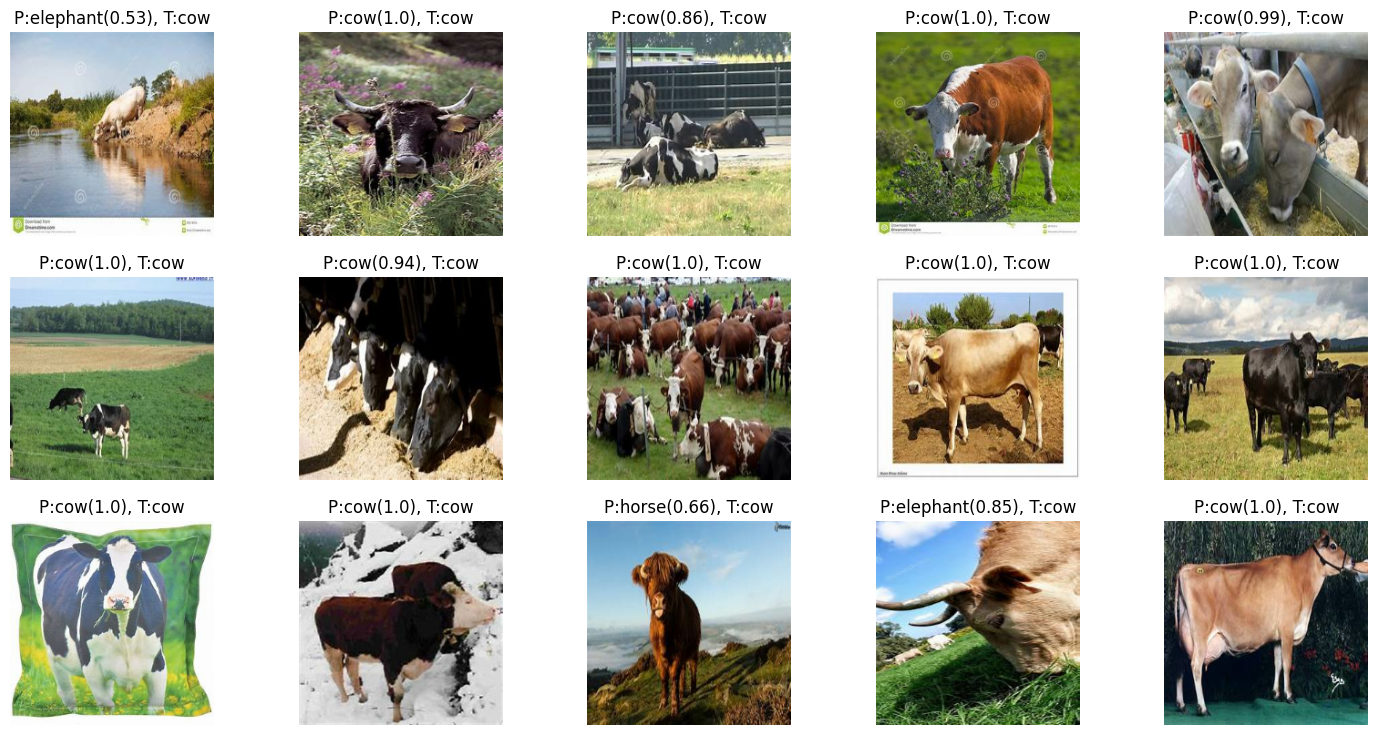

In [12]:
valid_dataset = tf.keras.utils.image_dataset_from_directory(
  DatasetConfig.VALID_DIR,
  label_mode='int',
  color_mode='rgb',
  batch_size=1,
  image_size=DatasetConfig.SHAPE[:2],
  shuffle=False, # shuffling to show images from all classes
)

get_sample_predictions(model=trained_model, dataset=valid_dataset)

# <font style="color:red">Step 6. Displaying Mistakes [10 points]</font>

The above code displayed sample predictions. But correct predictions are of no use. So, write a similar function such that it displays only the mistakes made by the network.


**You have to display 10 images wrongly predicted from the Validation set.**

1/1 [==============================] - 0s 186ms/step


<ipython-input-20-b2d24c1326fb>:23: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if pred_idx != truth_idx:


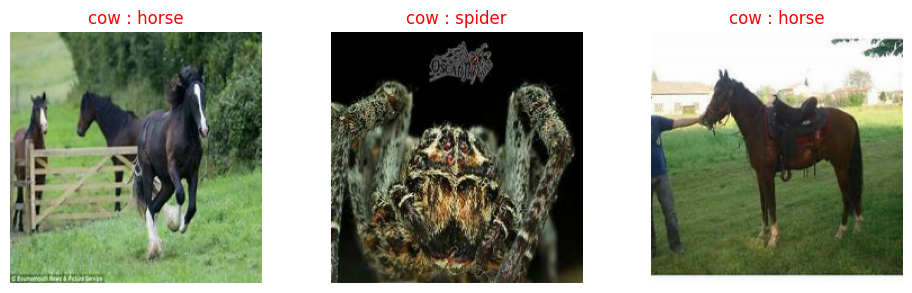

In [20]:
### YOUR CODE HERE
def display_wrong_predictions(model, dataset):

  plt.figure(figsize=(20, 15))
  num_rows = 4
  num_cols = 5
  class_names = dataset.class_names
  jdx = 0

  # Evaluate all the batches.
  for image_batch, labels_batch in dataset:

    # Predictions for the current batch.
    predictions = model.predict(image_batch)

    # Loop over all the images in the current batch.
    for idx in range(len(labels_batch)):

      pred_idx = tf.argmax(predictions[idx]).numpy()
      truth_idx = np.nonzero(labels_batch[idx].numpy())

      # Plot the images with incorrect predictions
      if pred_idx != truth_idx:
          jdx += 1
          if jdx > num_rows*num_cols:
            # Break from the loops if the maximum number of images have been plotted
            break

          ax = plt.subplot(num_rows, num_cols, jdx)
          title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
          title_obj = plt.title(title)
          plt.setp(title_obj, color='r')
          plt.axis("off")
          plt.imshow(image_batch[idx].numpy().astype("uint8"))

    return


display_wrong_predictions(model=trained_model, dataset=valid_dataset)
###

**Upon completing the project, <font style="color:red">upload the notebook to the lab for grading and feedback.</font>**

**<font style="color:red">Please do not make your notebooks public or publish them on the competition page. You only need to submit your notebook to the lab. This is to make sure that students don't copy each other.</font>**

# <font style="color:red">Step 7. Display Confusion Matrix [5 Points]</font>

Display the confusion matrix (Refer to the earlier lectures on Performance Metrics for this).


This is what the output should look like:

<img src='https://learnopencv.com/wp-content/uploads/2022/02/c4_project_a1_confusion_matrix.png' width=600>


25/25 [==============================] - 13s 504ms/step


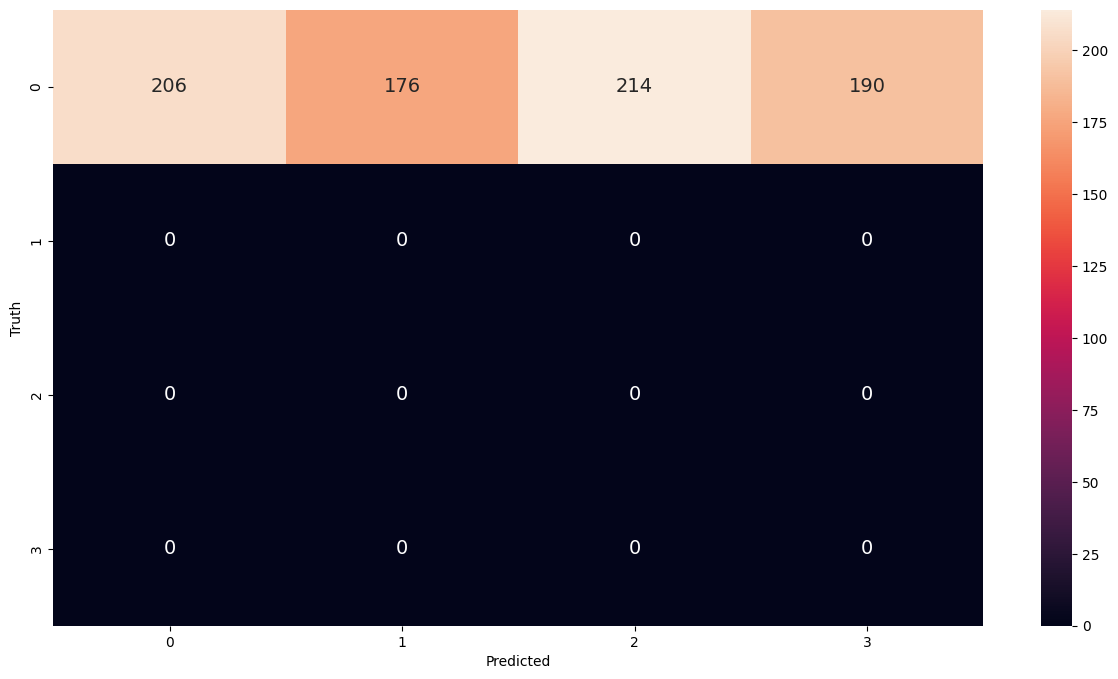

In [20]:
### YOUR CODE HERE

valid_labels = [int(np.argmax(label.numpy())) for _, label in valid_dataset]

predictions = trained_model.predict(valid_ds)
predicted_labels = [np.argmax(i) for i in predictions]

cm = tf.math.confusion_matrix(labels=valid_labels, predictions=predicted_labels)

plt.figure(figsize=[15, 8])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

###

# <font style="color:red">Step 7. Generate Submission File [5 Points]</font>


**TASK**

1. Generate predictions on the test set.
2. Create a submission `.csv` file.
3. Upload the `.csv` file on Kaggle.


**REFERENCE**
1. **`test.csv`** -  This CSV file contains image IDs for the test set. Read this CSV file to generate predictions for each test image.

2. **`sample_submission.csv`** - Refer to this file to understand the structure of the csv file to be submitted. The sample_submission file is only to be used as reference. <br>
It contains columns:
    1. **`ID`**: same as the test.csv file
    2. **`CLASS`**: which contains random predictions




**<font style="color:red">Use the same column names that are given in the`sample_submission.csv` file.</font>**


In [30]:
import pandas as pd

test_images = sorted(glob.glob(f"{DatasetConfig.TEST_DIR}/*.jpg"))

test_ds = tf.keras.utils.image_dataset_from_directory(
    DatasetConfig.TEST_DIR,
    label_mode=None,  # Set label_mode to None to create a dataset without labels
    color_mode='rgb',
    batch_size=1,
    image_size=DatasetConfig.SHAPE[:2],  # Set your desired image size
    shuffle=False  # No need to shuffle test data
)


# Define a function for making predictions on the test dataset
def make_predictions_and_save_csv(model, test_ds, test_images, idx_to_cls, csv_filename="submission.csv"):
  predictions = model.predict(test_ds)

  predicted_labels = [idx_to_cls[np.argmax(pred)] for pred in predictions]

  # Extract image IDs from the test dataset
  image_ids = [os.path.basename(image) for image in test_images]

  # Create a DataFrame with image IDs and predicted classes
  submission_df = pd.DataFrame({
    'ID': image_ids,
    'CLASS': predicted_labels
  })
  # Save the DataFrame to a CSV file
  submission_df.to_csv(csv_filename, index=False)


make_predictions_and_save_csv(
  trained_model,
  test_ds,
  test_images,
  {0: "cow", 1: "elephant", 2: "horse", 3: "spider"},
  TrainingConfig.SUBMISSION_DIR,
)

Found 1639 files belonging to 1 classes.
1639/1639 [==============================] - 18s 11ms/step


## <font style="color:red">Step 8. Kaggle Submission Score [50 Points]</font>

**For full points, you need to achieve atleast `85%` accuracy on the Public Test leaderboard. If accuracy is less than `80%`, you gain no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, in order to get evaluated for this section.**

**Please share your profile link, user id and score achieved.**

```
URL: https://www.kaggle.com/darkestmedium
Profile Name: darkestmedium
Points Scored: 0.95848
```

**Upon completing the project, <font style="color:red">upload the notebook to the lab for grading and feedback.</font>**

**<font style="color:red">Please do not make your notebooks public or publish them on the competition page. You only need to submit your notebook to the lab. This is to make sure that students don't copy each other.</font>**